# Who to Believe in Come Postseason?

Each baseball season there are certain to be teams that get you asking the question "Can they win it all?" As I'm writing this, my mind is turned to the 2021 SF Giants who got off to a hot start and just never cooled off. They currently have the best record in baseball after not being given a chance at the start of the season. However, there is certainly still a narative that come postseason, the teams that were supposed to be good going into the season will edge them out. I believe there are a couple things coming in to play here, but I wanted to look at the playoffs of the 2010's to see if there is any good way to measure how a baseball team will perform in the playoffs. 

Now there is so much randomness when it comes to the playoffs that there isn't going to be great way to predict playoff success. However, I wanted to look at 3 metrics that I believe could be useful in determining how a team performs. 

1. Top 3 starter performance- How good were their best 3 starters during the year
2. Top 4 reliever performance- How good were their best 4 relievers during the year
3. Hitting against top pitchers- How good was their offense against the best pitchers in the game (who they will be hitting against in the playoffs)

This is certainly an oversimplification of the things that can go into playoff success, but I believe it will be an interesting thing to look at. Truth be told this idea came from metric 3. The San Fransisco Giants of 2021 haven't hit great against great starting pitching and I wonder if that spells gloom for them in the postseason.

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.multicomp

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import os
import random

import warnings
warnings.filterwarnings("ignore")

## Import Data

After loading most of the necessary packages, there are 3 datasets to import. Below are the necessary indices and variables from each of the original data sets

In [147]:
random.seed(4)
start_vars = ['Name', 'Tm', 'IP', 'G', 'GS','ERA+','Year']
game_ind = [0,3,6,9,10,39,67,101,103]
team_dict = {'NYA':'NYY','NYN':'NYM','SDN':'SDP','SLN':'STL','SFN':'SFG','FLO':'FLA','LAN':'LAD','WAS':'WSN','TBA':'TBR','KCA':'KCR','CHN':'CHC','CHA':'CHW','ANA':'LAA'}
game_vars = ['date','tm_away','tm_hm','runs_away','runs_home','er_away','er_home','pitch_id_away','pitch_id_home']

### Playoff Results Data

Data for each playoff season from 2010 through 2019 that includes the number of wins in the playoffs and the result of the team from 0 to 4 where 0 would be lost in the wild card round and 4 would be winning the World Series.

In [148]:
playoffs = pd.read_csv("playoff_teams.csv",header=0)
playoffs['Year']=playoffs['Year'].astype(str)
playoffs.rename(columns={'Team':'Tm'},inplace=True)


### Pitching Data
Data for every pitcher from 2010 through 2019 and their individual stat lines. This is split into two dataframes for relievers and for starters. This data was available on baseball-reference.com.

In [83]:
directory = 'pitchers/'
pitchers_df = pd.DataFrame(columns=start_vars)
for filename in os.listdir(directory):
    year = str.split(filename,"_")[0]
    df = pd.read_csv(directory+filename,header=0)
    df['Year'] = year
    df = df[start_vars]
    pitchers_df = pd.concat([pitchers_df,df], ignore_index=True)
#Splitting up the name of the pitchers into id and actual name
pitchers_df['player_id']=pitchers_df['Name'].str.split("\\",expand=True)[1]
pitchers_df['Name']=pitchers_df['Name'].str.split("\\",expand=True)[0]
#Setting up the player id to match the format of the player id from Retrosheets
pitchers_df['player_id']=pitchers_df['player_id'].str[:-5]+pitchers_df['player_id'].str[-4:-3]+'0'+pitchers_df['player_id'].str[-2:]

#Dealing with trades by replacing the individual team totals with the season totals for a player
trades = pitchers_df[pitchers_df['Tm']=='TOT']
pitchers_df = pd.merge(pitchers_df, trades, how='left', on= ['Year','player_id','Name'])
pitchers_df.loc[pitchers_df['Tm_y']=='TOT','IP_x'] = pitchers_df.loc[pitchers_df['Tm_y']=='TOT','IP_y']
pitchers_df.loc[pitchers_df['Tm_y']=='TOT','G_x'] = pitchers_df.loc[pitchers_df['Tm_y']=='TOT','G_y']
pitchers_df.loc[pitchers_df['Tm_y']=='TOT','GS_x'] = pitchers_df.loc[pitchers_df['Tm_y']=='TOT','GS_y']
pitchers_df.loc[pitchers_df['Tm_y']=='TOT','ERA+_x'] = pitchers_df.loc[pitchers_df['Tm_y']=='TOT','ERA+_y']
pitchers_df.drop(columns=['Tm_y','IP_y','G_y','GS_y','ERA+_y'],inplace=True)
pitchers_df.rename(columns={'Tm_x':'Tm','IP_x':'IP','G_x':'G','GS_x':'GS','ERA+_x':'ERA+'},inplace=True)

#Drop all 'total' pitcher records now that they have been duplicated
pitchers_df = pitchers_df[pitchers_df['Tm']!='TOT']

#Creating additional variables
pitchers_df['IP_G'] = pitchers_df['IP']/pitchers_df['G'].astype(float)
#Splitting into relievers and starters based on GS vs Games. If more than half of the games were starts than classifying as a starting pitcher.
pitchers_df['Type']='SP'
pitchers_df.loc[pitchers_df['GS']/pitchers_df['G']<0.5,'Type'] = 'RP'

starter_df = pitchers_df[pitchers_df['Type']=='SP']
reliever_df = pitchers_df[pitchers_df['Type']=='RP']

### Game Log Data
Game log data from Retrosheet.org that includes who the starting pitcher was that day.

In [149]:
directory = 'games/'
game_df = pd.DataFrame(columns=game_vars)
for filename in os.listdir(directory):
    df = pd.read_csv(directory+filename,header=None)
    df = df[game_ind]
    df.columns = game_vars
    game_df = pd.concat([game_df,df], ignore_index=True)
#Matching the team abbrieviations to the other data sets
game_df.replace({'tm_away':team_dict,'tm_hm':team_dict},inplace=True)
game_df['Year'] = game_df.date.astype(str).str[:4]

The game logs include both teams per data point so the data needs to be "duplicated" in order to assess each game from each teams point of view. To do I created two dataframes, one for home teams and one for away teams, and then concatenated them. 'opp_er' is the number of earned runs the opponent gave up. The average across the data set is about 4.

4.052331563567519


Text(0.5, 1.0, 'Histogram of Earned Runs per Game')

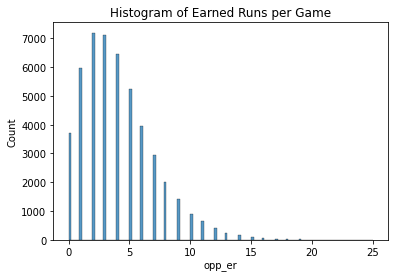

In [150]:
away_game = game_df.rename(columns={'tm_away':'Tm','tm_hm':'Opp_Tm','runs_away':'r','runs_home':'opp_r','er_away':'er','er_home':'opp_er','pitch_id_away':'starter','pitch_id_home':'opp_starter'})
home_game = game_df.rename(columns={'tm_hm':'Tm','tm_away':'Opp_Tm','runs_home':'r','runs_away':'opp_r','er_home':'er','er_away':'opp_er','pitch_id_home':'starter','pitch_id_away':'opp_starter'})
home_game = home_game[['date','Tm','Opp_Tm','r','opp_r','er','opp_er','starter','opp_starter']]
all_games = pd.concat([away_game,home_game],ignore_index=True)
print(all_games['opp_er'].mean())
sns.histplot(x='opp_er',data=all_games)
plt.title('Histogram of Earned Runs per Game')

## Feature Creation

### Top Starters

To rank the pitchers I am using ERA+ which is an advanced statistic where 100 is league average and adjusts for park factors. I am going to rank all the starting pitchers per team per year that have met a certain number of innings pitched (set to the mean of the dataset). Then taking the average of the best 3 starters that for each team (penalizing teams that do not have 3 pitchers that qualify).

In [264]:
pitch_ranking_metric = 'ERA+'
starter_num = 3
ip_qual = round(starter_df['IP'].mean())
#Rank starters by year and team
starter_df.sort_values(['Tm','Year',pitch_ranking_metric],ascending=[True,True,False], inplace=True, ignore_index=True)
#Limit search to starters that met the qs threshold
top_starters = starter_df.loc[starter_df['IP']>=ip_qual]
top_starters = top_starters.groupby(['Tm','Year']).head(starter_num)
team_starters = top_starters.groupby(['Tm','Year']).sum()
team_starters.reset_index(inplace=True)
team_starters = team_starters[['Tm','Year','ERA+']]
team_starters.rename(columns={'ERA+':'SP_ERA+'},inplace=True)
team_starters['SP_ERA+'] = team_starters['SP_ERA+']/starter_num
print(team_starters.sort_values('SP_ERA+',ascending=False))
top_starters.loc[(top_starters['Tm']=='HOU')&(top_starters['Year']=='2019')]

      Tm  Year     SP_ERA+
111  HOU  2019  173.000000
296  WSN  2017  169.333333
46   CHC  2016  167.333333
136  LAD  2015  165.000000
78   CLE  2018  163.000000
..   ...   ...         ...
209  PIT  2010   77.333333
146  MIA  2017   65.666667
282  TOR  2013   65.666667
82   COL  2012   31.000000
67   CIN  2017   27.000000

[299 rows x 3 columns]


,Name,Tm,IP,G,GS,ERA+,Year,player_id,IP_G,Type
946,Gerrit Cole,HOU,212.1,33,33,185.0,2019,colg001,6.427273,SP
947,Justin Verlander,HOU,223.0,34,34,179.0,2019,verlj001,6.558824,SP
948,Zack Greinke,HOU,208.2,33,33,155.0,2019,greiz001,6.309091,SP


The results line up here as the top teams all had amazing pitching staffs and the bottom teams had some rough years. 

### Ace Starters

To find the true "aces" through the years, I am limiting the starters list to only starters that were at least 50% better than their peers, pitched an average of at least 6 innings per start and meeting the innings threshold.

['Robbie Ray*', 'Zack Greinke', 'Mike Soroka', 'Clay Buchholz', 'Jon Lester*', 'Chris Sale*', 'Jake Arrieta', 'Kyle Hendricks', 'Johnny Cueto', 'Sonny Gray', 'Corey Kluber', 'Trevor Bauer', 'Mike Clevinger', 'Ubaldo Jimenez', 'Kyle Freeland*', 'Justin Verlander', 'Anibal Sanchez', 'David Price*', 'Josh Johnson', 'Dallas Keuchel*', 'Gerrit Cole', 'Jered Weaver', 'Clayton Kershaw*', 'Alex Wood*', 'Hyun Jin Ryu*', 'Jose Fernandez', 'Junior Guerra', 'Chase Anderson', 'Matt Harvey', 'Noah Syndergaard', 'Jacob deGrom', 'Luis Severino', 'Roy Halladay', 'Cliff Lee*', 'Cole Hamels*', 'Aaron Nola', 'Felix Hernandez', 'Adam Wainwright', 'Jaime Garcia*', 'Jack Flaherty', 'Blake Snell*', 'C.J. Wilson*', 'Doug Fister', 'Tanner Roark', 'Max Scherzer', 'Stephen Strasburg', 'Gio Gonzalez*']
74


<AxesSubplot:xlabel='Year', ylabel='Count'>

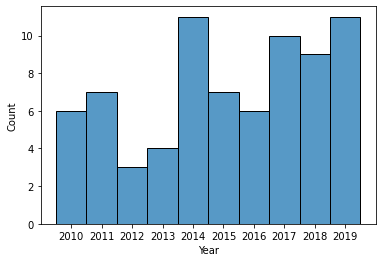

In [266]:
ace_starters = starter_df.loc[(starter_df['ERA+']>=150)&(starter_df['IP_G']>=5)&(starter_df['IP']>=ip_qual)]
ace_starters.reset_index(inplace=True)
print(list(ace_starters['Name'].unique()))
print(len(ace_starters))
sns.histplot(x='Year',data=ace_starters.sort_values('Year'))

Now that is some list. An average of just over 7 pitchers per season. 2012 and 2013 only had a handfull of elite pitchers, but that is okay. Some sure fire hall of famers mixed with some guys who put together some fantastic seasons.

### Games against Aces

Combining the list of ace starts with the games logs allows us to look at how each team hit against the best starters during the regular season.

2.7003525264394828


<AxesSubplot:xlabel='opp_er', ylabel='Count'>

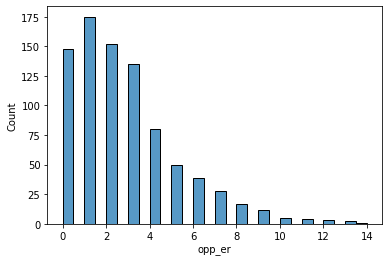

In [267]:
games_vs_ace = pd.merge(ace_starters[['Year','player_id']],all_games,left_on=['player_id','Year'],right_on=['opp_starter','Year'])
games_vs_ace['opp_er']=games_vs_ace['opp_er'].astype(float)
print(games_vs_ace['opp_er'].mean())
sns.histplot(x='opp_er',data=games_vs_ace, binwidth=.5)

The average against aces is down about 1.3 runs per game compared to the overall list of games from this decade.

In order to match this data with the rest of our data, this should be grouped by team and year.

In [270]:
team_vs_ace = games_vs_ace.groupby(['Tm','Year']).agg({'opp_er':['mean','count']})
team_vs_ace.reset_index(inplace=True)
team_vs_ace.columns = ['Tm','Year','opp_er','count']
print(team_vs_ace[team_vs_ace['count']>=3].sort_values('opp_er', ascending=False).head(10))

      Tm  Year    opp_er  count
141  MIL  2019  8.000000      4
16   ATL  2017  7.833333      6
97   HOU  2018  7.333333      3
240  TBR  2019  6.333333      3
217  SFG  2014  5.400000      5
165  NYY  2015  5.142857      7
211  SEA  2018  5.000000      3
185  PHI  2019  4.833333      6
84   DET  2014  4.800000      5
266  WSN  2019  4.750000      4


### Top Relievers

Performing a similar exercise as we did with the starters to get the teams with the best relievers.

In [272]:
reliever_num = 5
ip_qual = round(reliever_df['IP'].mean())

reliever_df.sort_values(['Tm','Year',pitch_ranking_metric],ascending=[True,True,False], inplace=True, ignore_index=True)

top_relievers = reliever_df.loc[reliever_df['IP']>=ip_qual]
top_relievers = top_relievers.groupby(['Tm','Year']).head(reliever_num)
team_relievers = top_relievers.groupby(['Tm','Year']).sum()
team_relievers.reset_index(inplace=True)
team_relievers = team_relievers[['Tm','Year','ERA+']]
team_relievers.rename(columns={'ERA+':'RP_ERA+'},inplace=True)
team_relievers['RP_ERA+'] = team_relievers['RP_ERA+']/reliever_num
print(team_relievers.sort_values('RP_ERA+',ascending=False).head(10))
top_relievers.loc[(top_relievers['Tm']=='STL')&(top_relievers['Year']=='2013')]

      Tm  Year  RP_ERA+
253  STL  2013    288.4
26   BAL  2016    276.0
262  TBR  2012    250.6
12   ATL  2012    244.0
116  KCR  2014    239.4
273  TEX  2013    237.8
181  NYY  2011    233.8
198  OAK  2018    222.0
117  KCR  2015    215.0
76   CLE  2016    213.2


,Name,Tm,IP,G,GS,ERA+,Year,player_id,IP_G,Type
4511,Kevin Siegrist*,STL,39.2,45,0,832.0,2013,siegk001,0.871111,RP
4513,Randy Choate*,STL,35.1,64,0,165.0,2013,choar001,0.548438,RP
4514,Seth Maness,STL,62.0,66,0,162.0,2013,manes001,0.939394,RP
4515,Trevor Rosenthal,STL,75.1,74,0,143.0,2013,roset001,1.014865,RP
4516,Joe Kelly,STL,124.0,37,15,140.0,2013,kellj005,3.351351,RP


## Combining with Playoff Results

Merging the top 3 starter ERA+ average with the playoff average to start creating the master dataframe that we can use to analyze.

In [273]:
playoff_starters = pd.merge(playoffs,team_starters,how='right',right_on=['Tm','Year'],left_on=['Tm','Year'])
games_vs_ace['opp_er']=games_vs_ace['opp_er'].astype(float)
#Teams that were not in the playoffs are given a 0 for wins, round, and 'PostSeason' which designates making the postseason.
playoff_starters['PostSeason']='Made Postseason'
playoff_starters.loc[playoff_starters['Result'].isnull(),'PostSeason']='Missed Postseason'
#Don't count wildcard losers as making the playoffs since it is just a 1 game series
playoff_starters.loc[playoff_starters['Result']==0,'PostSeason']='Missed Postseason'
playoff_starters.loc[playoff_starters['Result'].isnull(),['Wins','Result']]=0

Plotting each teams starting pitching against their playoff wins, shows minimal correlation between the top 3 starters and the result in the postseason. There is a clear dropoff in pitching performance for some non playoff teams. It would appear that if your top 3 starters are not all above average (100 ERA+) then you have no shot at the postseason.

Text(0.5, 1.0, 'Top 3 Starter ERA+ vs Playoff Wins')

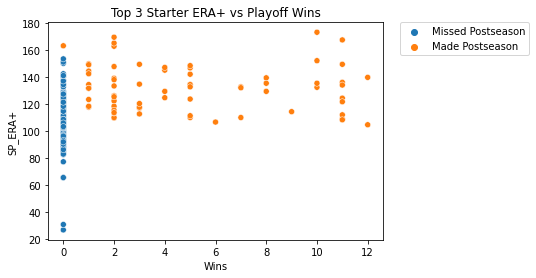

In [274]:
sns.scatterplot(x='Wins',y='SP_ERA+',hue='PostSeason',data=playoff_starters)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Top 3 Starter ERA+ vs Playoff Wins')

Adding in the performance of each team against aces. I had to account for small sample sizes as some teams did not play against aces very often some years. I replaced the values in those cases with the overall average of runs scored against aces for that year. The average is typically around 2.5 runs against the ace depending on the year.

In [276]:
playoffs_df = pd.merge(playoff_starters,team_vs_ace,how='left',left_on=['Tm','Year'],right_on=['Tm','Year'])
#Get median of runs scored by year
yearly_avg = games_vs_ace[['Year','opp_er']]
yearly_avg['er_avg'] = yearly_avg['opp_er'].astype(float)
yearly_avg = yearly_avg[['Year','er_avg']].groupby('Year').mean()
yearly_avg.reset_index(inplace=True)
#Replace values with less than 3 games with the median
playoffs_df = pd.merge(playoffs_df,yearly_avg,how='left',on='Year')
playoffs_df.loc[playoffs_df['count']<3,'opp_er'] = playoffs_df['er_avg']
playoffs_df.loc[playoffs_df['count'].isnull(),'opp_er'] = playoffs_df['er_avg']
print(yearly_avg)

#Create full df with all data needed
full_df = pd.merge(playoffs_df,team_relievers,how='left',left_on=['Tm','Year'],right_on=['Tm','Year'])
full_df.drop(columns=['count','er_avg'],inplace=True)
#Max out wins at 11 for scale (only two teams had 12 wins from wildcard play ins)
full_df.loc[full_df['Wins']>11,'Wins'] = 11

   Year    er_avg
0  2010  2.586957
1  2011  2.701754
2  2012  2.127660
3  2013  2.258065
4  2014  2.291391
5  2015  2.303030
6  2016  2.575342
7  2017  3.279070
8  2018  2.964602
9  2019  3.500000


Plotting the runs scored against ace pitchers honestly was not as insightful as I would have liked. There isn't much of a trend within the playoff teams and the variance of the non playoff teams encompasses playoff teams. Hopefully this can be useful in conjunction with the other variables.

I believe a big part of the issue here is that this metric is for the entire game against the ace pitcher rather than just the innings against them. There is certainly the possibility of some of these numbers being skewed by games where the bullpen let in runs.

Text(0.5, 1.0, 'Runs Scored Against Ace Pitchers vs Playoff Wins')

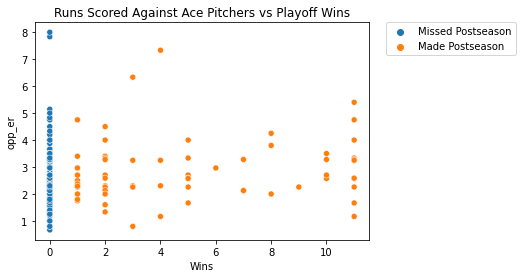

In [277]:
sns.scatterplot(x='Wins',y='opp_er',hue='PostSeason',data=full_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Runs Scored Against Ace Pitchers vs Playoff Wins')

Plotting the top relief pitchers against the number of playoff wins. There is definitely a bit of a trend here. This may be a bit of a self-fulfilling prophecy due to the fact that a couple of teams won world series off of the strength of their bullpens this decade. Kansas City, I'm looking at you.

Text(0.5, 1.0, 'Top 3 Releiver ERA+ vs Playoff Wins')

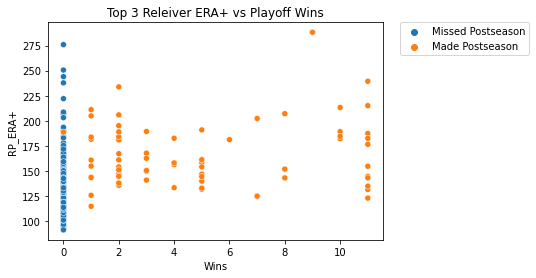

In [280]:
sns.scatterplot(x='Wins',y='RP_ERA+',hue='PostSeason',data=full_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Top 3 Releiver ERA+ vs Playoff Wins')

Creating a dataframe for only postseason teams for the model

In [286]:
post_df = full_df[full_df['PostSeason']=='Made Postseason'].drop(columns='PostSeason')

Plotting the pair plot of all of the data

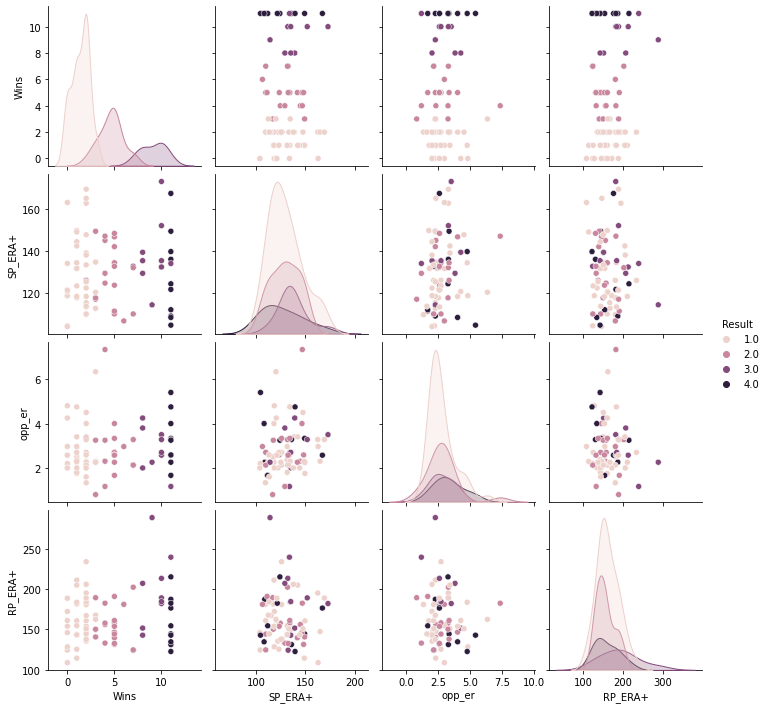

In [287]:
sns.pairplot(data=post_df, hue='Result')

Looking at the correlation matrix confirms what we saw in the scatter plot. There is minimal correlation with the starting pitcher ERA+, a bit more with the runs against aces, and a bit more with the bullpen ERA+.

<AxesSubplot:>

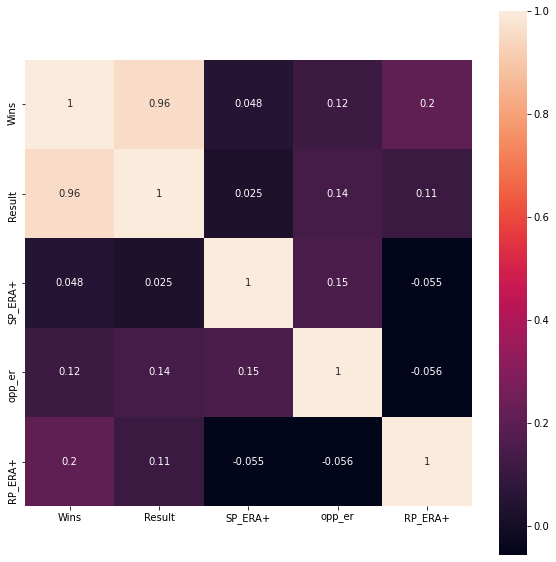

In [288]:
plt.figure(figsize=(10,10))
sns.heatmap(post_df.corr(), square=True, annot=True)

## Training the model

Importing all of the packages I wanted to use

In [289]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

I am going to run multiple models with cross validation and look at the scores to determine which might be best to use.

In [290]:
def test_models(models,X,y):
    for model in models:
        cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
        n_scores = cross_val_score(model, X, y, scoring = 'neg_mean_absolute_error', cv=cv, n_jobs=-1)
        print(model,' MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

The models I am running are random forest, ada boost regressor, and gradient boost regressor. All of these are more complex versions of a decision tree that will allow our very non linear data to hopefully be modelled accurately. I will be using mean absolute error to evaluate models

In [291]:
models = [RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor()]

X = post_df[['SP_ERA+','opp_er','RP_ERA+']]
y = post_df['Wins']

test_models(models,X,y)

RandomForestRegressor()  MAE: -3.648 (0.659)
AdaBoostRegressor()  MAE: -3.531 (0.637)
GradientBoostingRegressor()  MAE: -3.918 (0.697)


After running all of the models, ada boost looks like the best. However there are hyper parameters for each of these models that can be tuned.

## Tuning hyperparameters

I will be using GridSearchCV() to tune the hyperparameters of each model and then take the best estimator

### Random Forest

In [303]:
param_grid = {
    'n_estimators': [50, 100,150],
    'min_samples_leaf': [1,2],
    'min_samples_split': [2, 3],
    'random_state': [4]
}

grid_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=4)
model = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, scoring = 'neg_mean_absolute_error', cv = grid_cv, verbose=2, n_jobs = -1)
model.fit(X,y)
print(model.best_params_)
print(model.best_score_)
best_RF = model.best_estimator_


Fitting 15 folds for each of 12 candidates, totalling 180 fits
{'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 4}
-3.2825331587702418


### Ada Boost

In [297]:
param_grid = {
    'n_estimators': [50,100,150],
    'loss': ['linear','square','exponential'],
    'random_state': [4]
}

grid_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=4)
model = GridSearchCV(estimator = AdaBoostRegressor(), param_grid = param_grid, scoring = 'neg_mean_absolute_error', cv = grid_cv, verbose=2, n_jobs = -1)
model.fit(X,y)
print(model.best_params_)
print(model.best_score_)
best_ada = model.best_estimator_


Fitting 15 folds for each of 9 candidates, totalling 135 fits
{'loss': 'exponential', 'n_estimators': 50, 'random_state': 4}
-3.3580210393412524


### Gradient Boost

In [298]:
param_grid = {
    'n_estimators': [50,100,150],
    'loss': ['ls','lad','huber'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2,3,4],
    'random_state': [4]
}

grid_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=4)
model = GridSearchCV(estimator = GradientBoostingRegressor(), param_grid = param_grid, scoring = 'neg_mean_absolute_error', cv = grid_cv, verbose=2, n_jobs = -1)
model.fit(X,y)
print(model.best_params_)
print(model.best_score_)
best_GB = model.best_estimator_

Fitting 15 folds for each of 81 candidates, totalling 1215 fits
{'loss': 'lad', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 4}
-3.3284299474469163


After tuning the hyperparameters, random forest was able to achieve the lowest mean absolute error. 

## Prediction

Taking the best model and inputing the data to receive the results allows us to plot the prediction against the actual result. This shows that the model struggles to predict the higher end of the wins spectrum. This sense since there is less data for the higher wins totals since only 1 team each year reaches the elusive 11 wins needed for a world series victory.

Text(0.5, 1.0, 'Predicted Win Total vs Actual Win Total')

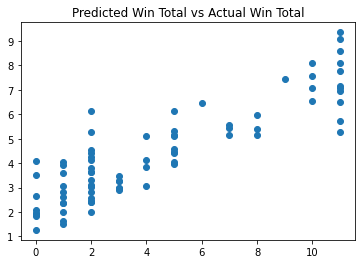

In [305]:
pred = best_RF.predict(X)
res = y-pred
plt.scatter(y,pred)
plt.title('Predicted Win Total vs Actual Win Total')

Adding code to add the prediction to the original dataframe

In [307]:
results_df = post_df
results_df['res'] = res
results_df['pred'] = pred

Looking at the top 5 teams that under performed based on the model, we see some very good teams. The 2011 Yankees were two years removed from a championship and still had the core including Jeter, A-Rod, Cano, Teixera, and Posada. The 2014 Tigers had a hall of fame staff with Scherzer, Verlander, Porcello, and Price. The 2018 Indians had a wealth of pitching as did those two Nationals teams.

In [309]:
results_df.sort_values('res').head(5)

,Year,Tm,Wins,Result,SP_ERA+,opp_er,RP_ERA+,res,pred
180,2011,NYY,2.0,1.0,126.000000,2.701754,233.8,-4.115667,6.115667
94,2014,DET,0.0,1.0,118.666667,4.800000,128.4,-4.104881,4.104881
78,2018,CLE,0.0,1.0,163.000000,2.964602,108.8,-3.512571,3.512571
296,2017,WSN,2.0,1.0,169.333333,3.279070,188.8,-3.280429,5.280429
293,2014,WSN,1.0,1.0,142.333333,3.400000,204.8,-3.053667,4.053667


Looking at the teams that most over performed ends up being a list of world series champs plus the 2017 Dodgers. This is because as I mentioned the data is skewed towards lower win totals.

In [257]:
results_df.sort_values('res',ascending=False).head(5)

,Year,Tm,Wins,Result,SP_ERA+,opp_er,RP_ERA+,res,pred
241,2012,SFG,11.0,4.0,112.000000,1.666667,154.4,6.515312,4.484688
239,2010,SFG,11.0,4.0,121.666667,2.586957,182.4,5.134112,5.865888
33,2013,BOS,11.0,4.0,109.000000,2.258065,187.2,5.070775,5.929225
46,2016,CHC,11.0,4.0,167.333333,2.333333,176.4,4.974150,6.025850
138,2017,LAD,10.0,3.0,152.000000,3.226667,189.0,4.590601,5.409399


We can look at all of the predicted champions based on the model by taking the highest predicted win total from the bunch. The deviations from reality occur with the 2010 Texas Rangers, 2012 Tigers, 2014 Royals, and 2016 Indians. The losers of this deal are the Cubs who still haven't broken their curse and the Giants. The Giants actually end up losing 3 championships! Maybe there was some truth to that even year BS. 

In [310]:
champs = results_df.sort_values(['Year','pred'],ascending=[True,False]).head(100)
champs.groupby('Year').head(1)

,Year,Tm,Wins,Result,SP_ERA+,opp_er,RP_ERA+,res,pred
269,2010,TEX,8.0,3.0,129.333333,3.800000,207.0,2.043222,5.956778
250,2011,STL,11.0,4.0,108.333333,4.000000,134.6,2.417690,8.582310
92,2012,DET,7.0,3.0,132.666667,2.127660,124.2,1.560952,5.439048
252,2013,STL,9.0,3.0,114.333333,2.258065,288.4,1.550000,7.450000
116,2014,KCR,11.0,3.0,134.000000,1.166667,239.4,2.888000,8.112000
117,2015,KCR,11.0,4.0,124.333333,3.250000,215.0,3.213333,7.786667
76,2016,CLE,10.0,3.0,132.333333,2.575342,213.2,1.921333,8.078667
109,2017,HOU,11.0,4.0,136.000000,3.279070,131.2,1.938667,9.061333
38,2018,BOS,11.0,4.0,149.333333,3.333333,144.4,3.833048,7.166952
298,2019,WSN,11.0,4.0,139.666667,4.750000,122.6,1.642595,9.357405


We can also model all of the non playoff teams to see who may have made some noise if they had been able to make it in. The top choice is the 2019 Mets which makes sense due to their elite pitching staff, decent bullpen, and breakout offense that included ROY winner Pete Alonso.

In [312]:
full_X = full_df[['SP_ERA+','opp_er','RP_ERA+']]
full_y = full_df['Wins']

full_pred = best_RF.predict(full_X)
full_res = full_y-full_pred

full_results_df = full_df
full_results_df['res'] = full_res
full_results_df['pred'] = full_pred

full_results_df[full_results_df['PostSeason']=='Missed Postseason'].sort_values('pred',ascending=False).head(5)

,Year,Tm,Wins,Result,SP_ERA+,PostSeason,opp_er,RP_ERA+,res,pred
178,2019,NYM,0.0,0.0,137.333333,Missed Postseason,4.200000,122.4,-9.227405,9.227405
121,2019,KCR,0.0,0.0,107.666667,Missed Postseason,3.500000,118.4,-8.392548,8.392548
283,2014,TOR,0.0,0.0,106.000000,Missed Postseason,4.333333,113.4,-8.186881,8.186881
3,2013,ARI,0.0,0.0,106.333333,Missed Postseason,4.000000,127.6,-7.922310,7.922310
208,2019,PHI,0.0,0.0,105.333333,Missed Postseason,4.833333,127.8,-7.622310,7.622310


## Conclusion

In conclusion, predicting playoff success is very difficult for a multitude of reasons. However, this was a very interesting exercise to go through that led to some fun discoveries about some teams from the past decade. 

This type of model is never going to be perfect as well due to the fact that the playoffs are not round-robin but match up based. So a team may be the second best team and have to play the best team in the first round.

Some things to add to improve the model:
- Better injury designation- I'm potentially using players that were injured in my calculations for the playoffs
- Better runs against ace stat- I'm using total earned runs scored that game which almost certainly includes the bullpen
- Record the last 10 games before the playoffs- Potentially shows how "hot" the team is
- Better Starting Pitching stat- I'm using an average which didn't correlate too well. I wonder if breaking out the top 3 to 4 starters individually would provide better results
- More data- The more years of data, the better the model should get